## Imports

In [1]:
import pandas as pd
from glob import glob
import os
from shutil import copyfile
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18,resnet34,densenet121
from torchvision.models.inception import inception_v3
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pickle
%matplotlib inline


In [2]:
is_cuda = torch.cuda.is_available()
is_cuda

True

## Utility functions

In [3]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)
    
class FeaturesDataset(Dataset):
    
    def __init__(self,featlst1,featlst2,featlst3,labellst):
        self.featlst1 = featlst1
        self.featlst2 = featlst2
        self.featlst3 = featlst3
        self.labellst = labellst
        
    def __getitem__(self,index):
        return (self.featlst1[index],self.featlst2[index],self.featlst3[index],self.labellst[index])
    
    def __len__(self):
        return len(self.labellst)
    
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data1,data2,data3,target) in enumerate(data_loader):
        if is_cuda:
            data1,data2,data3,target = data1.cuda(),data2.cuda(),data3.cuda(),target.cuda()
        data1,data2,data3,target = Variable(data1,volatile),Variable(data2,volatile),Variable(data3,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data1,data2,data3)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).data[0]
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

class LayerActivations():
    features=[]
    
    def __init__(self,model):
        self.features = []
        self.hook = model.register_forward_hook(self.hook_fn)
    
    def hook_fn(self,module,input,output):
        #out = F.avg_pool2d(output, kernel_size=8)
        self.features.extend(output.view(output.size(0),-1).cpu().data)

    
    def remove(self):
        
        self.hook.remove()
    

## Creating PyTorch datasets

In [4]:
data_transform = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [5]:
# For Dogs & Cats dataset
train_dset = ImageFolder('../../chapter5/dogsandcats/train/',transform=data_transform)
val_dset = ImageFolder('../../chapter5/dogsandcats/valid/',transform=data_transform)
classes=2

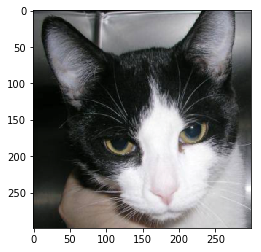

In [6]:
imshow(train_dset[150][0])

## Creating data loader for training and validation datasets

In [7]:
train_loader = DataLoader(train_dset,batch_size=32,shuffle=False,num_workers=3)
val_loader = DataLoader(val_dset,batch_size=32,shuffle=False,num_workers=3)

## Creating models

In [8]:
#Create ResNet model
my_resnet = resnet34(pretrained=True)

if is_cuda:
    my_resnet = my_resnet.cuda()

my_resnet = nn.Sequential(*list(my_resnet.children())[:-1])

for p in my_resnet.parameters():
    p.requires_grad = False

#Create inception model

my_inception = inception_v3(pretrained=True)
my_inception.aux_logits = False
if is_cuda:
    my_inception = my_inception.cuda()
for p in my_inception.parameters():
    p.requires_grad = False

#Create densenet model

my_densenet = densenet121(pretrained=True).features
if is_cuda:
    my_densenet = my_densenet.cuda()
    
for p in my_densenet.parameters():
    p.requires_grad = False

## Extract convolution features from ResNet , Inception and DenseNet

In [9]:
### For ResNet

trn_labels = []
trn_resnet_features = []
for d,la in train_loader:
    o = my_resnet(Variable(d.cuda()))
    o = o.view(o.size(0),-1)
    trn_labels.extend(la)
    trn_resnet_features.extend(o.cpu().data)
val_labels = []
val_resnet_features = []
for d,la in val_loader:
    o = my_resnet(Variable(d.cuda()))
    o = o.view(o.size(0),-1)
    val_labels.extend(la)
    val_resnet_features.extend(o.cpu().data)

### For Inception

trn_inception_features = LayerActivations(my_inception.Mixed_7c)
for da,la in train_loader:
    _ = my_inception(Variable(da.cuda()))

trn_inception_features.remove()

val_inception_features = LayerActivations(my_inception.Mixed_7c)
for da,la in val_loader:
    _ = my_inception(Variable(da.cuda()))

val_inception_features.remove()

### For Densenet


trn_densenet_features = []
for d,la in train_loader:
    o = my_densenet(Variable(d.cuda()))
    o = o.view(o.size(0),-1)
    
    trn_densenet_features.extend(o.cpu().data)
    

val_densenet_features = []
for d,la in val_loader:
    o = my_densenet(Variable(d.cuda()))
    o = o.view(o.size(0),-1)
    val_densenet_features.extend(o.cpu().data)

## Create Dataset for train and val

In [10]:
trn_feat_dset = FeaturesDataset(trn_resnet_features,trn_inception_features.features,trn_densenet_features,trn_labels)
val_feat_dset = FeaturesDataset(val_resnet_features,val_inception_features.features,val_densenet_features,val_labels)

## Create Dataloader for train and val

In [11]:
trn_feat_loader = DataLoader(trn_feat_dset,batch_size=64,shuffle=True)
val_feat_loader = DataLoader(val_feat_dset,batch_size=64)

## Create an Ensemble model

In [12]:
class EnsembleModel(nn.Module):
    
    def __init__(self,out_size,training=True):
        super().__init__()
        self.fc1 = nn.Linear(8192,512)
        self.fc2 = nn.Linear(131072,512)
        self.fc3 = nn.Linear(82944,512)
        self.fc4 = nn.Linear(512,out_size)

    def forward(self,inp1,inp2,inp3):
        out1 = self.fc1(F.dropout(inp1,training=self.training))
        out2 = self.fc2(F.dropout(inp2,training=self.training))
        out3 = self.fc3(F.dropout(inp3,training=self.training))
        out = out1 + out2 + out3
        out = self.fc4(F.dropout(out,training=self.training))
        return out

In [13]:
em = EnsembleModel(2)
if is_cuda:
    em = em.cuda()

In [14]:
optimizer = optim.Adam(em.parameters(),lr=0.01)

## Train the ensemble model

In [15]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,em,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,em,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is 6.2e+01 and training accuracy is 21419/23000     93.13
validation loss is 1e+02 and validation accuracy is 1909/2000     95.45
training loss is 8.3e+01 and training accuracy is 22537/23000     97.99
validation loss is 1.2e+02 and validation accuracy is 1962/2000      98.1
training loss is 1.2e+02 and training accuracy is 22654/23000      98.5
validation loss is 2.7e+02 and validation accuracy is 1961/2000     98.05
training loss is 1.1e+02 and training accuracy is 22808/23000     99.17
validation loss is 1.2e+02 and validation accuracy is 1989/2000     99.45
training loss is 1.2e+02 and training accuracy is 22821/23000     99.22
validation loss is 3.1e+02 and validation accuracy is 1978/2000      98.9
training loss is 9.7e+01 and training accuracy is 22879/23000     99.47
validation loss is 2.5e+02 and validation accuracy is 1987/2000     99.35
training loss is 1.1e+02 and training accuracy is 22881/23000     99.48
validation loss is 2.2e+02 and validation accuracy is 